# Notebook 02: Data Cleaning and Validation

**Traveco Transport Forecasting Project**

## Objective
Clean and validate the order analysis data based on insights from notebook 01:
1. Handle missing values
2. Convert data types (especially dates and numerics)
3. Remove duplicates
4. Validate business rules
5. Create clean dataset for feature engineering

## Outputs
- `data/processed/clean_orders.csv` - Clean dataset ready for feature engineering
- Data quality report

---

## 1. Setup and Imports

In [33]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Custom utilities
import sys
sys.path.append('..')  # Add parent directory to path
from utils.traveco_utils import (
    ConfigLoader,
    TravecomDataLoader,
    TravecomDataCleaner,
    save_processed_data
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Setup complete!")

Setup complete!


## 2. Load Data

In [34]:
# Load configuration
config = ConfigLoader('../config/config.yaml')

# Load data
loader = TravecomDataLoader(config)
df_orders = loader.load_order_analysis()

print(f"Loaded {len(df_orders):,} orders with {len(df_orders.columns)} columns")

Loading order analysis from: ../data/swisstransfer_f473fe80-56b4-4ff0-8cbb-1bb5e181450a/20251015 Juni 2025 QS Auftragsanalyse.xlsb
Loaded 136,159 orders with 103 columns
Loaded 136,159 orders with 103 columns


## 3. Apply Business Filtering Rules

In [ ]:
# Apply filtering (CORRECTED per Christian's feedback - Oct 2025)
# Applies TWO filters in sequence:
# 1. Lager (warehouse) orders: Lieferart 2.0 == 'Lager Auftrag'
# 2. B&T pickup orders: System='B&T' AND Customer (RKdNr) is empty
cleaner = TravecomDataCleaner(config)
df = cleaner.apply_filtering_rules(df_orders)

print(f"\nFiltered dataset: {len(df):,} rows")
print(f"Retention rate: {(len(df) / len(df_orders) * 100):.2f}%")

## 4. Handle Missing Values

### 4.1 Analyze Missing Values

In [36]:
# Calculate missing values
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df) * 100).round(2)

missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percent': missing_pct
}).sort_values('Missing_Count', ascending=False)

# Show only columns with missing values
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]

print(f"Columns with missing values: {len(missing_summary)}")
print("\nTop 20 columns by missing percentage:")
missing_summary.head(20)

Columns with missing values: 27

Top 20 columns by missing percentage:


,Missing_Count,Missing_Percent
Kontraktauftrag Nummer,135047,99.56
Text2.Auftrag,126019,92.90
Text3.Auftrag,116483,85.87
Text1.Auftrag,114520,84.43
Name1.Artikel,92893,68.48
Nummer.Artikel,92893,68.48
Liefergebiet.Auftrag,73446,54.15
Vertreter.Auftrag,70701,52.12
Versender Name 2,40802,30.08
Empfänger Name2,39748,29.30


### 4.2 Missing Value Strategy

Strategy for handling missing values:
1. **Critical columns** (dates, IDs): Drop rows if missing
2. **Numeric columns** (revenue, costs): Keep as 0 or NaN for aggregation
3. **Categorical columns**: Keep as "Unknown" category
4. **Optional columns**: Keep as-is

In [37]:
# Define critical columns that should not have missing values
critical_columns = [
    'Nummer.Auftrag',  # Order number
    'Datum.Tour',      # Tour date
]

# Check which critical columns exist
existing_critical = [col for col in critical_columns if col in df.columns]

print(f"Critical columns found: {existing_critical}")

# Check missing values in critical columns
for col in existing_critical:
    missing = df[col].isnull().sum()
    if missing > 0:
        print(f"\n⚠️  {col}: {missing:,} missing values ({missing/len(df)*100:.2f}%)")
    else:
        print(f"✓ {col}: No missing values")

Critical columns found: ['Nummer.Auftrag', 'Datum.Tour']
✓ Nummer.Auftrag: No missing values
✓ Datum.Tour: No missing values


In [38]:
# Drop rows with missing critical values
print(f"\nRows before dropping: {len(df):,}")

for col in existing_critical:
    before = len(df)
    df = df.dropna(subset=[col])
    after = len(df)
    if before != after:
        print(f"Dropped {before - after:,} rows due to missing {col}")

print(f"\nRows after dropping: {len(df):,}")


Rows before dropping: 135,646

Rows after dropping: 135,646


## 5. Data Type Conversions

### 5.1 Convert Date Columns

In [39]:
# Identify and convert date columns
potential_date_columns = ['Datum.Tour', 'tour_start_date']
date_columns_to_convert = [col for col in potential_date_columns if col in df.columns]

print("Converting date columns...")

# Import feature engine for proper conversion
from utils.traveco_utils import TravecomFeatureEngine
feature_engine = TravecomFeatureEngine(config)

for col in date_columns_to_convert:
  print(f"\n{col}:")

  # Show original state
  print(f"  Original type: {df[col].dtype}")
  if pd.api.types.is_numeric_dtype(df[col]):
      print(f"  Sample raw values (Excel serial): {df[col].head(3).tolist()}")

  # Convert using proper Excel date converter
  df[col] = feature_engine.convert_date_column(df[col])

  print(f"  ✓ Converted to: {df[col].dtype}")
  print(f"  Range: {df[col].min()} to {df[col].max()}")
  print(f"  Span: {(df[col].max() - df[col].min()).days} days")

Converting date columns...

Datum.Tour:
  Original type: int64
  Sample raw values (Excel serial): [45809, 45809, 45809]
  ✓ Converted to: datetime64[ns]
  Range: 2025-06-01 00:00:00 to 2025-06-30 00:00:00
  Span: 29 days


### 5.2 Convert Numeric Columns

In [40]:
# Identify numeric columns that should be numeric
numeric_columns = [
    'Distanz_BE.Auftrag',  # Distance
    'Nummer.Spedition',    # Carrier number
    # Add other numeric columns as identified
]

numeric_cols_to_convert = [col for col in numeric_columns if col in df.columns]

print("Converting numeric columns...")
for col in numeric_cols_to_convert:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"✓ {col}: Converted to numeric")
        print(f"  Range: {df[col].min():.2f} to {df[col].max():.2f}")
        print(f"  Mean: {df[col].mean():.2f}")
    except Exception as e:
        print(f"✗ {col}: Conversion failed - {e}")

Converting numeric columns...
✓ Distanz_BE.Auftrag: Converted to numeric
  Range: 1.00 to 407.00
  Mean: 62.93
✓ Nummer.Spedition: Converted to numeric
  Range: 1100.00 to 9851.00
  Mean: 5106.37


## 6. Remove Duplicates

In [41]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates:,}")

if duplicates > 0:
    print(f"\nRemoving {duplicates:,} duplicate rows...")
    df = df.drop_duplicates()
    print(f"New row count: {len(df):,}")
else:
    print("No duplicate rows found!")

Total duplicate rows: 0
No duplicate rows found!


## 7. Data Validation

### 7.1 Validate Business Rules

In [42]:
print("Validating business rules...")
print("="*60)

# Rule 1: Carrier numbers should be > 0
if 'Nummer.Spedition' in df.columns:
    invalid_carriers = (df['Nummer.Spedition'] <= 0).sum()
    print(f"\n1. Carrier Numbers <= 0: {invalid_carriers:,}")
    
    # Check carrier type distribution
    if 'carrier_type' in df.columns:
        print(f"   Carrier type distribution:")
        print(df['carrier_type'].value_counts())

# Rule 2: Distance should be >= 0
if 'Distanz_BE.Auftrag' in df.columns:
    negative_distance = (df['Distanz_BE.Auftrag'] < 0).sum()
    print(f"\n2. Negative distances: {negative_distance:,}")
    if negative_distance > 0:
        print("   ⚠️  Found negative distances - may need investigation")

# Rule 3: Check date ranges
if date_columns_to_convert:
    date_col = date_columns_to_convert[0]
    print(f"\n3. Date Range ({date_col}):")
    print(f"   Min: {df[date_col].min()}")
    print(f"   Max: {df[date_col].max()}")
    print(f"   Span: {(df[date_col].max() - df[date_col].min()).days} days")

print("\n" + "="*60)

Validating business rules...

1. Carrier Numbers <= 0: 0

2. Negative distances: 0

3. Date Range (Datum.Tour):
   Min: 2025-06-01 00:00:00
   Max: 2025-06-30 00:00:00
   Span: 29 days



### 7.2 Statistical Validation

Distance Statistics (Distanz_BE.Auftrag):
count    129684.000000
mean         62.928357
std          47.687109
min           1.000000
25%          29.000000
50%          51.000000
75%          83.000000
max         407.000000
Name: Distanz_BE.Auftrag, dtype: float64


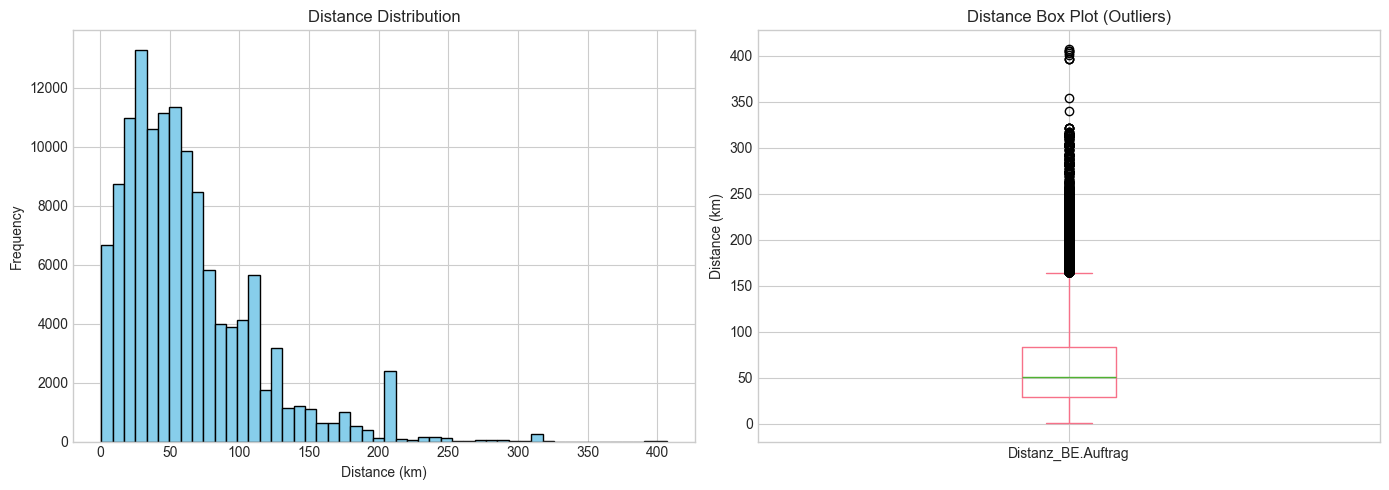


Extreme outliers (>3 IQR): 569 (0.42%)


In [43]:
# Check for outliers in numeric columns
if 'Distanz_BE.Auftrag' in df.columns:
    print("Distance Statistics (Distanz_BE.Auftrag):")
    print(df['Distanz_BE.Auftrag'].describe())
    
    # Visualize distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    df['Distanz_BE.Auftrag'].hist(bins=50, ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Distance (km)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distance Distribution')
    
    # Box plot
    df['Distanz_BE.Auftrag'].plot(kind='box', ax=axes[1], vert=True)
    axes[1].set_ylabel('Distance (km)')
    axes[1].set_title('Distance Box Plot (Outliers)')
    
    plt.tight_layout()
    plt.show()
    
    # Identify extreme outliers
    Q1 = df['Distanz_BE.Auftrag'].quantile(0.25)
    Q3 = df['Distanz_BE.Auftrag'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df['Distanz_BE.Auftrag'] < (Q1 - 3*IQR)) | 
                (df['Distanz_BE.Auftrag'] > (Q3 + 3*IQR))).sum()
    print(f"\nExtreme outliers (>3 IQR): {outliers:,} ({outliers/len(df)*100:.2f}%)")

## 8. Create Derived Columns

In [44]:
# Add carrier type classification (if not already done)
if 'carrier_type' not in df.columns and 'Nummer.Spedition' in df.columns:
    internal_max = config.get('filtering.internal_carrier_max', 8889)
    external_min = config.get('filtering.external_carrier_min', 9000)
    
    df['carrier_type'] = df['Nummer.Spedition'].apply(
        lambda x: 'internal' if pd.notna(x) and x <= internal_max
                 else 'external' if pd.notna(x) and x >= external_min
                 else 'unknown'
    )
    print("✓ Added carrier_type column")

# Map Tilde to readable order type
if 'Tilde.Auftrag' in df.columns and 'order_type' not in df.columns:
    df['order_type'] = df['Tilde.Auftrag'].map({
        'Ja': 'Pickup',
        'Nein': 'Delivery'
    })
    print("✓ Added order_type column")

# Extract year and month for easier aggregation
if date_columns_to_convert:
    date_col = date_columns_to_convert[0]
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['year_month'] = df[date_col].dt.to_period('M')
    print("✓ Added year, month, and year_month columns")

✓ Added carrier_type column
✓ Added order_type column
✓ Added year, month, and year_month columns


## 9. Final Data Quality Check

In [45]:
# Run final validation
print("Final Data Quality Check")
print("="*60)

validation_results = cleaner.validate_data(df)

print(f"\nData types summary:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"  {dtype}: {count} columns")

Final Data Quality Check

Data Validation Summary:
  Total rows: 135,646
  Total columns: 108
  Duplicate rows: 0
  Columns with missing values: 30

Data types summary:
  object: 90 columns
  float64: 12 columns
  int64: 2 columns
  int32: 2 columns
  datetime64[ns]: 1 columns
  period[M]: 1 columns


## 10. Save Clean Dataset

In [46]:
# Save to processed data folder
output_filename = config.get('data.clean_orders', 'clean_orders.csv')

print(f"Saving clean dataset...")
save_processed_data(df, output_filename, config)

print(f"\n✓ Clean dataset saved successfully!")
print(f"  Location: data/processed/{output_filename}")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")

Saving clean dataset...
Saved 135,646 rows to: ../data/processed/clean_orders.csv

✓ Clean dataset saved successfully!
  Location: data/processed/clean_orders.csv
  Rows: 135,646
  Columns: 108


## 11. Generate Data Quality Report

In [ ]:
# Create detailed quality report (CORRECTED per Christian's feedback - Oct 2025)
import json

quality_report = {
    'metadata': {
        'corrections_applied': 'Christian Haller feedback - October 2025',
        'filtering_sequence': ['1. Lager orders (warehouse)', '2. B&T pickup orders']
    },
    'original_rows': int(len(df_orders)),
    'after_filtering': int(len(df)),
    'rows_removed': int(len(df_orders) - len(df)),
    'retention_rate': f"{(len(df) / len(df_orders) * 100):.2f}%",
    'total_columns': int(len(df.columns)),
    'duplicate_rows_removed': int(duplicates),
    'missing_values': {
        'total_columns_with_missing': int(len(missing_summary)),
        'top_5_missing': {str(k): float(v) for k, v in missing_summary.head(5)['Missing_Percent'].to_dict().items()} if not missing_summary.empty else {}
    },
    'data_types': {
        str(dtype): int(count) for dtype, count in df.dtypes.value_counts().items()
    },
    'derived_columns_added': [
        'carrier_type',
        'order_type',
        'year',
        'month',
        'year_month'
    ]
}

if date_columns_to_convert:
    date_col = date_columns_to_convert[0]
    quality_report['date_range'] = {
        'column': date_col,
        'min': str(df[date_col].min()),
        'max': str(df[date_col].max()),
        'span_days': int((df[date_col].max() - df[date_col].min()).days)
    }

# Save report
results_path = Path('../results')
results_path.mkdir(exist_ok=True)

with open(results_path / 'data_quality_report.json', 'w') as f:
    json.dump(quality_report, f, indent=2)

print("✓ Quality report saved to: results/data_quality_report.json")

## 12. Summary and Next Steps

In [ ]:
print("=" * 80)
print("DATA CLEANING SUMMARY (CORRECTED - Christian's Feedback Oct 2025)")
print("=" * 80)

print(f"\n📊 DATASET TRANSFORMATION:")
print(f"   Original rows: {len(df_orders):,}")
print(f"   Clean rows: {len(df):,}")
print(f"   Rows removed: {len(df_orders) - len(df):,} ({((len(df_orders) - len(df))/len(df_orders)*100):.2f}%)")
print(f"   Retention rate: {(len(df) / len(df_orders) * 100):.2f}%")

print(f"\n✂️  FILTERING RULES APPLIED (in sequence):")
print(f"   1. Lager (warehouse) orders: Lieferart 2.0 == 'Lager Auftrag'")
print(f"   2. B&T pickup orders: System='B&T' AND RKdNr is empty")
print(f"   → Both filters ensure accurate operational analysis")

print(f"\n✨ IMPROVEMENTS MADE:")
print(f"   ✓ Applied corrected business filtering rules")
print(f"   ✓ Removed {duplicates:,} duplicate rows")
print(f"   ✓ Converted {len(date_columns_to_convert)} date columns")
print(f"   ✓ Converted {len(numeric_cols_to_convert)} numeric columns")
print(f"   ✓ Added 5 derived columns (carrier_type, order_type, year, month, year_month)")
print(f"   ✓ Validated business rules")

print(f"\n💾 OUTPUT:")
print(f"   File: data/processed/{output_filename}")
print(f"   Size: {len(df):,} rows × {len(df.columns)} columns")

print(f"\n➡️  NEXT STEPS:")
print(f"   Proceed to notebook 03: Feature Engineering (CORRECTED)")
print(f"   - Multi-field order type classification (K+AU+CW)")
print(f"   - Betriebszentralen mapping with BZ 10→9000 merge")
print(f"   - TRAVECO Intern Sparte category for internal orders")
print(f"   - Extract temporal features")
print(f"   - Calculate time decay weights")

print("\n" + "=" * 80)

---

## Conclusion

This notebook successfully cleaned and validated the Traveco order data:
- Applied business filtering rules
- Handled missing values appropriately
- Converted data types for analysis
- Removed duplicates
- Added derived columns for easier analysis
- Created a clean dataset ready for feature engineering

**Next:** Proceed to `03_feature_engineering.ipynb` to extract features for forecasting models.